In [12]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

## Preprocess data

In [22]:
npis = [
    "C1M",
    "C2M",
    "C3M",
    "C4M",
    "C5M",
    "C6M",
    "C7M",
    "C8M",
    "H1"
    ]
npi_labels = [
    "School closing",
    "Workplace closing",
    "Cancel public events",
    "Restrictions on gatherings",
    "Close public transport",
    "Stay at home requirements",
    "Restrictions on internal movement",
    "International travel controls",
    "Public information campaigns"
]

df = pd.read_csv("./OxCGRT_clean.csv", sep=',')

si = df["StringencyIndex_Average"].values
si = si/100
si = si[:16000]

prev_day = df["C1M"].values[1:]
prev_day = prev_day[:16000]
samples = np.column_stack((si,prev_day))
labels = [df["C1M"].values[:16000]]


for npi in npis[1:]:
  prev_day = df[npi].values[1:]
  prev_day = prev_day[:16000]
  samples = np.column_stack((samples,prev_day))
  labels.append(df[npi].values[:16000])

samples, *labels = shuffle(samples, *labels, random_state=0)

train_labels = []
train_samples =[]
train_samples = samples[:15000]

for label in labels:
  train_labels.append(label[:15000])

test_labels = []
test_samples =[]
test_samples = samples[15000:15100]

for label in labels:
  test_labels.append(label[15000:15100])

## MTL model

In [14]:
from keras.optimizers import Adam
from keras import Input, Model
from keras.layers import Dense

num_tasks = 9
num_features = num_tasks + 1

shared_layer_1 = Dense(32, input_dim=num_features, activation='relu')
shared_layer_2 = Dense(32, activation='relu')

task_1_output_layer = Dense(5, activation='softmax', name='C1')
task_2_output_layer = Dense(5, activation='softmax', name='C2')
task_3_output_layer = Dense(5, activation='softmax', name='C3')
task_4_output_layer = Dense(5, activation='softmax', name='C4')
task_5_output_layer = Dense(5, activation='softmax', name='C5')
task_6_output_layer = Dense(5, activation='softmax', name='C6')
task_7_output_layer = Dense(5, activation='softmax', name='C7')
task_8_output_layer = Dense(5, activation='softmax', name='C8')
task_9_output_layer = Dense(5, activation='softmax', name='H1')

input_tensor = Input(shape=(num_features,))

shared_tensor = shared_layer_1(input_tensor)
shared_tensor = shared_layer_2(shared_tensor)

task_1_output = task_1_output_layer(shared_tensor)
task_2_output = task_2_output_layer(shared_tensor)
task_3_output = task_3_output_layer(shared_tensor)
task_4_output = task_4_output_layer(shared_tensor)
task_5_output = task_5_output_layer(shared_tensor)
task_6_output = task_6_output_layer(shared_tensor)
task_7_output = task_7_output_layer(shared_tensor)
task_8_output = task_8_output_layer(shared_tensor)
task_9_output = task_9_output_layer(shared_tensor)

mtl_model = Model(inputs=input_tensor, outputs=[
    task_1_output, 
    task_2_output,
    task_3_output, 
    task_4_output,
    task_5_output, 
    task_6_output,
    task_7_output, 
    task_8_output,
    task_9_output],)

mtl_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss={
            'C1': 'sparse_categorical_crossentropy',
            'C2': 'sparse_categorical_crossentropy',
            'C3': 'sparse_categorical_crossentropy',
            'C4': 'sparse_categorical_crossentropy',
            'C5': 'sparse_categorical_crossentropy',
            'C6': 'sparse_categorical_crossentropy',
            'C7': 'sparse_categorical_crossentropy',
            'C8': 'sparse_categorical_crossentropy',
            'H1': 'sparse_categorical_crossentropy'
            },
        metrics={
            'C1': 'accuracy',
            'C2': 'accuracy',
            'C3': 'accuracy',
            'C4': 'accuracy',
            'C5': 'accuracy',
            'C6': 'accuracy',
            'C7': 'accuracy',
            'C8': 'accuracy',
            'H1': 'accuracy'
            }
        )
mtl_model.summary()

mtl_model.fit(
    x=train_samples.reshape(-1,num_features),
    y=train_labels,
    validation_split=0.1,
    batch_size=10,
    epochs=10,
    shuffle=True,
    verbose=2
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 32)           352         ['input_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 32)           1056        ['dense_4[0][0]']                
                                                                                                  
 C1 (Dense)                     (None, 5)            165         ['dense_5[0][0]']                
                                                                                            

# Predict

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## test data

Accuracy: 0.820000


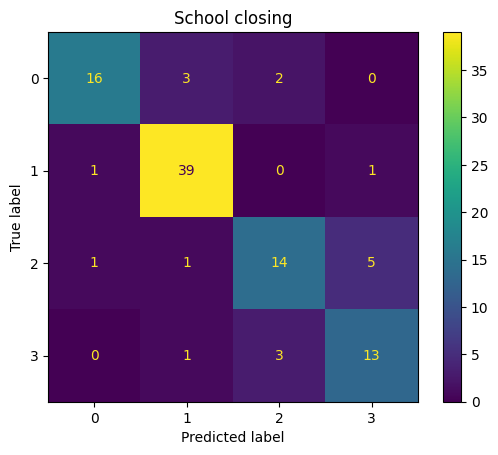

Accuracy: 0.880000


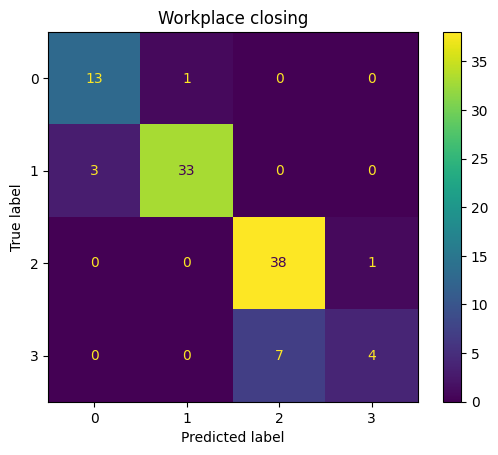

Accuracy: 0.880000


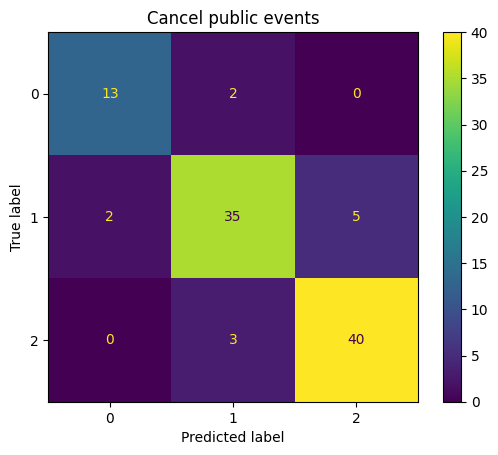

Accuracy: 0.740000


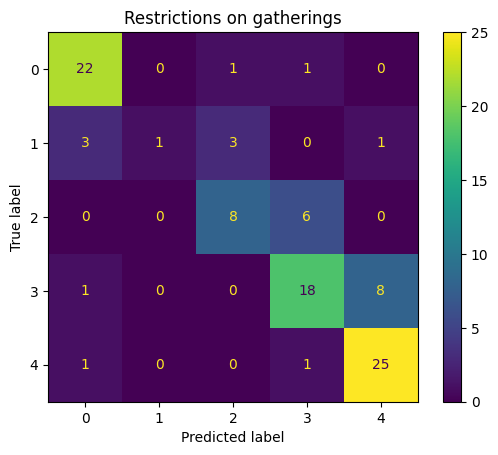

Accuracy: 0.940000


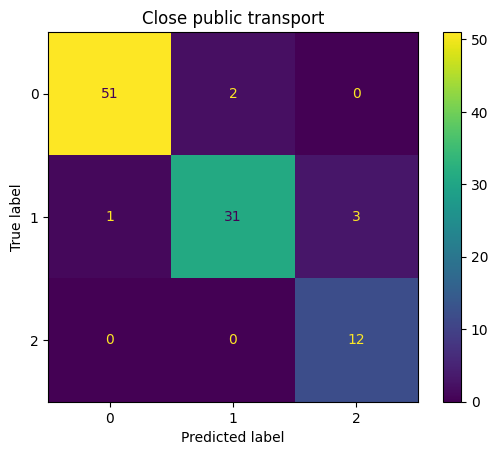

Accuracy: 0.930000


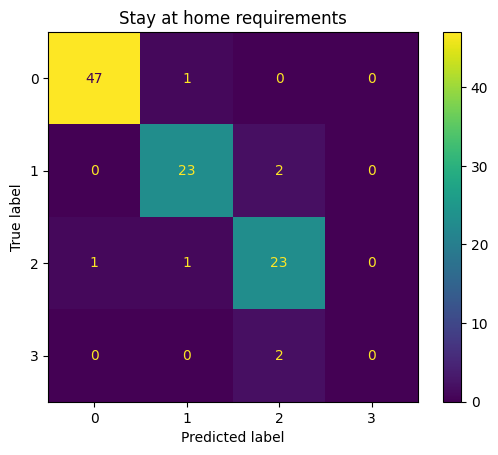

Accuracy: 0.870000


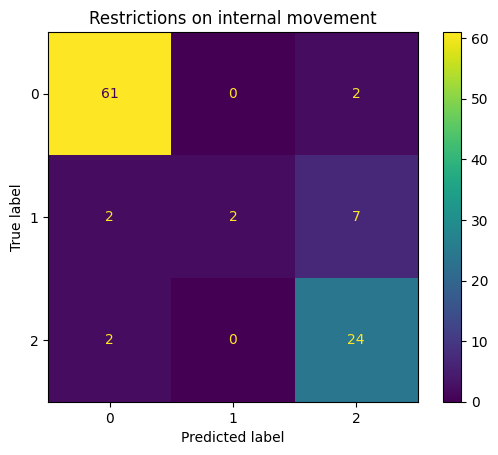

Accuracy: 0.810000


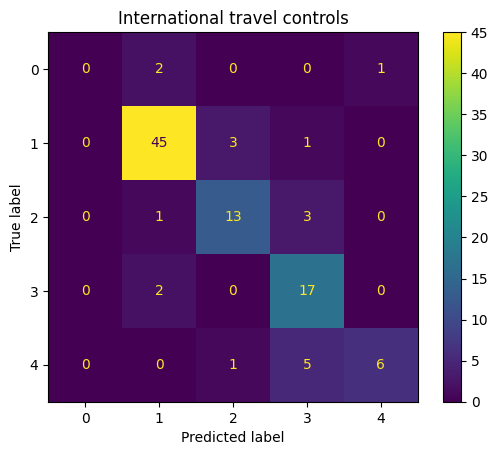

Accuracy: 0.930000


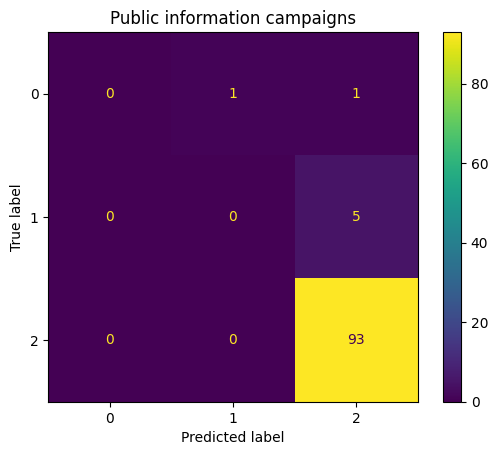

In [34]:
from sklearn.metrics import accuracy_score

predictions = mtl_model.predict(
    x=test_samples.reshape(-1,num_features),
    batch_size = 10,
    verbose = 0)

predictions = np.array(predictions)

f = lambda x: np.argmax(x, axis=-1)
predictions = f(predictions)

for idx, pred in enumerate(predictions):
  cm = confusion_matrix(y_true=test_labels[idx], y_pred=pred)
  accuracy = accuracy_score(test_labels[idx], pred).round(2)
  print("Accuracy: %f"%accuracy)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  disp.ax_.set_title(npi_labels[idx])
  plt.show()